# Kwaterniony model AR (Levinson-Durbin)
--- 

## Wczytanie danych
---

Stabilny zapis lotu `38_bs78_out_GPS_alt2pos.ulg`.

In [44]:
import pyulog
from library.data_reader import read_attitude_quaternions, read_nav_quaternions

log = pyulog.ULog('./ulogs/38_bs78_out_GPS_alt2pos.ulg')
att_q, att_t = read_attitude_quaternions(log)
nav_q, nav_t = read_nav_quaternions(log)

## Interpolacja
---

Zaimplementowano metodę bazującą na *interpolacja funkcjami sklejanymi*, jako `spline_interpolation()`, dostarczającą bliskie wyniki. Zaimplementowano również metodę bazującą na metodzie *slerp*, jako funkcję `squad_interpolation`.  

Dla zachowania ciągłości napisano funkcję zwracającą indeksy podsekwencji rozdzielonych maksymalną odległością `discontinued_subspaces`

In [67]:
import numpy as np
from library.quaternion_interp import discontinued_subspaces, spline_interpolation

# Get pseudo continuous signal (max space 10ms)
max_space = 10e4

args_partial_signal = discontinued_subspaces(att_t, max_length = max_space)
args_part = args_partial_signal[0] # Get first part

att_t = att_t[args_part[0]:args_part[1]]
att_q = att_q[args_part[0]:args_part[1]]

# Config interpolation
dt = 4000
degree = 3

est_t = np.arange(att_t[0], att_t[-1], dt)
est_q = spline_interpolation(att_q, att_t, est_t, spline_degree=degree)

### Wynik interpolacji (składowe kwaternionu)

Do wyświetlenie rezultatów można wykorzystać `display_quaternion_compare` dla składowych kwaternionu.

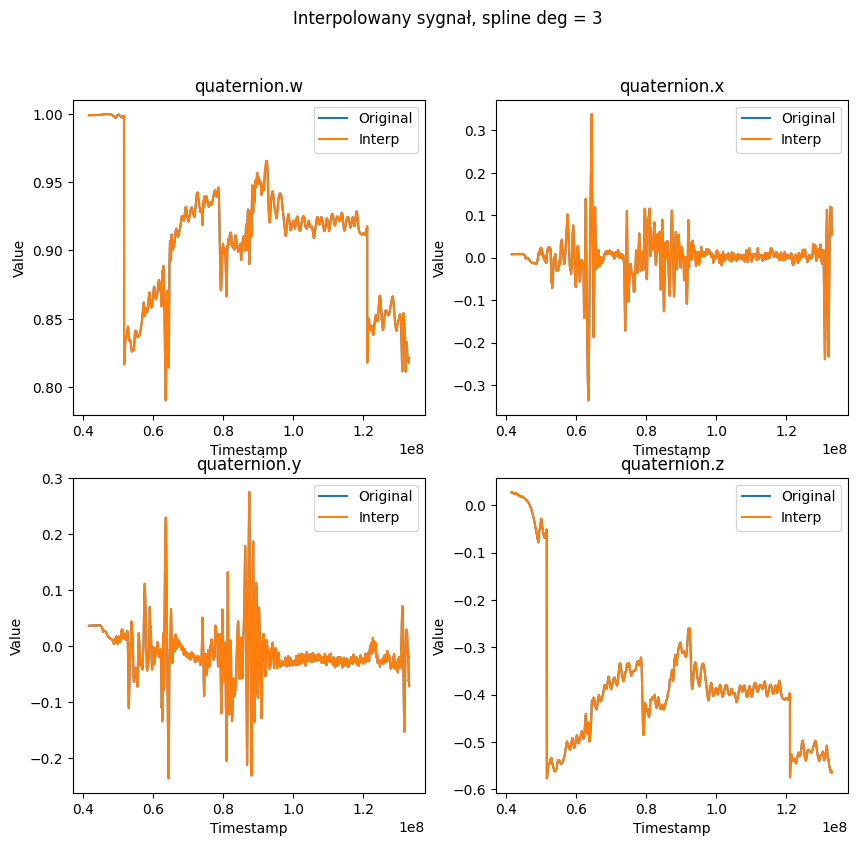

In [68]:
from library.quaternion_vision import display_quaternion_compare

display_quaternion_compare([att_q, est_q], [att_t, est_t], ['Original', 'Interp'],
    "Interpolowany sygnał, spline deg = {}".format(degree))

### Wynik interpolacji (kąty Eulera)

W przypadku kątów Eulera `display_quaternion_as_euler`. 

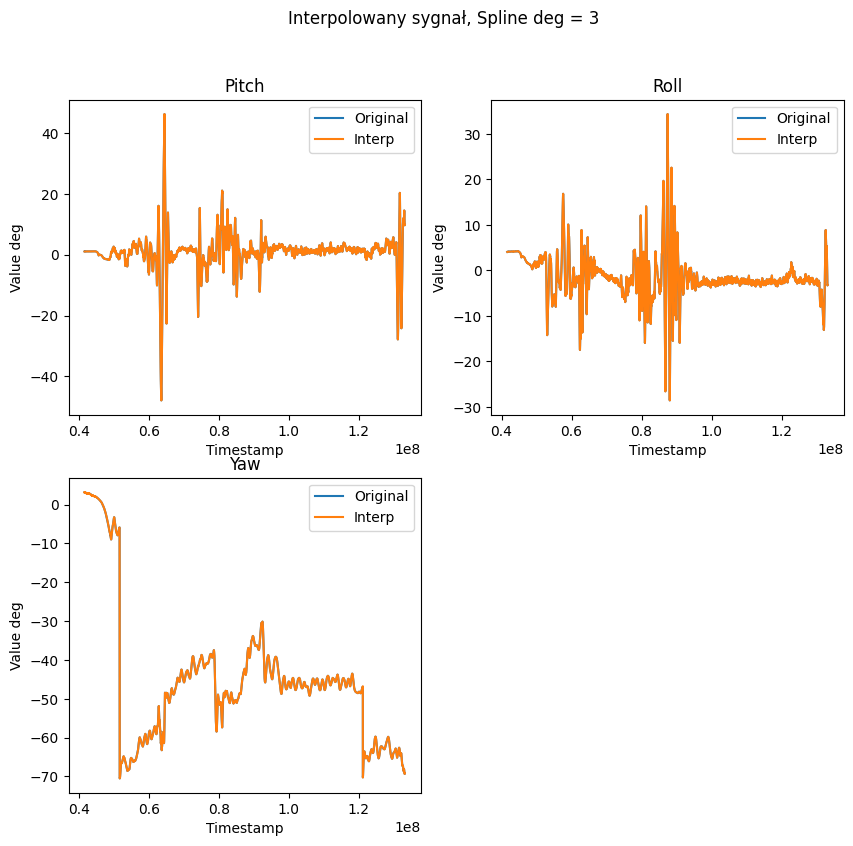

In [69]:
from library.quaternion_vision import display_quaternion_as_euler

display_quaternion_as_euler([att_q, est_q], [att_t, est_t], ['Original', 'Interp'],
    "Interpolowany sygnał, Spline deg = {}".format(degree))

## Implementacja modelu AR
---

### Macierz autokorelacji

\begin{bmatrix}
r_{0}(0) & \overline{r_{1}(1)} & \overline{r_{2}(2)} & \cdots  & \overline{r_{p}(p)}\\ 
r_{1}(1) & r_{1}(0) & \overline{r_{2}(1)} & \cdots & \overline{r_{p}(p-1)}\\ 
r_{2}(2) & r_{2}(1) & r_{2}(0) & \cdots & \overline{r_{p}(p-2)}\\ 
\vdots  & \vdots  & \vdots  & \ddots  & \vdots\\ 
r_{p}(p) & r_{p}(p-1) & r_{p}(p-2) & \cdots & r_{p}(0)
\end{bmatrix} 

\begin{bmatrix}
1\\ 
a_1\\ 
a_2\\ 
\vdots \\ 
a_p
\end{bmatrix}

In [70]:
def compute_correlation_matrix(windowing_signal: np.ndarray, M_order: int) -> np.ndarray :
    """
    Determines the quaternion correlation matrix.
    Args:
        windowing_signal (np.ndarray[np.quaternion]): Windowing signal
        M_order (int): Filter order

    Returns:
        np.ndarray[np.quaternion]: Corelation matrix 
    """
    n = windowing_signal.size
    r_size = M_order + 1

    r_matrix = np.zeros((r_size, r_size), dtype = np.quaternion)
    for i in range(0, (n - M_order - 1) ):
        v = windowing_signal[i : (i + M_order + 1)]
        r_matrix += np.outer(v, v.conjugate())
    
    return r_matrix

### Levinson-Durbin 

In [88]:
def compute_coefficient_LD(r_matrix: np.ndarray, M_order: int) -> np.ndarray:
    
    a_arr = np.zeros((0), dtype = np.quaternion)

    # Step 1: P=0 -> a0 = 1
    # Step 2: P=1
    a_arr = np.append(a_arr, r_matrix[1, 0] / r_matrix[0, 0])

    # Step 3: Iterative for P in (1 : M_order)
    for i in range(2, M_order + 1):
        nominator   = r_matrix[i, 0] - np.sum(a_arr * r_matrix[i,1:i])
        denominator = r_matrix[i, i]   - np.sum(a_arr[::-1] * r_matrix[i,1:i])
        temp_a = nominator / denominator

        # Coefficients actualization 
        a_arr = a_arr - temp_a * a_arr[::-1]

        # Add coefficient 
        a_arr = np.append(a_arr, temp_a)

    return a_arr

## Test predykcji
---

In [97]:
# Configuration section
N_window = 30
M_order = 3

pred_window = {
    'min': 5000 + N_window,
    'max': est_t.shape[0],
}
ex_q   = est_q[pred_window['min']:pred_window['max']]
pred_q = np.zeros((pred_window['max'] - pred_window['min']), dtype = np.quaternion)
ex_t = pred_t = est_t[pred_window['min']:pred_window['max']]

for i in range(pred_window['min'], pred_window['max']):
    r_matrix = compute_correlation_matrix(est_q[i-N_window : i][::-1], M_order)
    a_arr = compute_coefficient_LD(r_matrix, M_order)
    pred_q[i - pred_window['min']] = np.sum(a_arr * est_q[i-M_order : i][::-1]).normalized()


### Uzyskane rezultaty

#### MSE dla kątów Eulera

In [94]:
from library.quaternion_utils import quaternion_euler_mse, quaternion_euler_difference

EULER_COMPONENTS = ['Pitch', 'Roll', 'Yaw']
mse_e = quaternion_euler_mse(ex_q, pred_q)
for mse, c in zip(mse_e, EULER_COMPONENTS):
    print(f'{c+" mse:": <10} {mse}')

diff_e = quaternion_euler_difference(ex_q, pred_q)
max_e = np.max(diff_e, axis=0)
for max_e, c in zip(max_e, EULER_COMPONENTS):
    print(f'{c+" Max err :": <15} {max_e}')


Pitch mse: 0.0650418304227622
Roll mse:  0.054092153876740975
Yaw mse:   0.036093210320084314
Pitch Max err : 1.485868427020506
Roll Max err :  1.2679657113857274
Yaw Max err :   23.31698894396399


#### Wykres predykcji

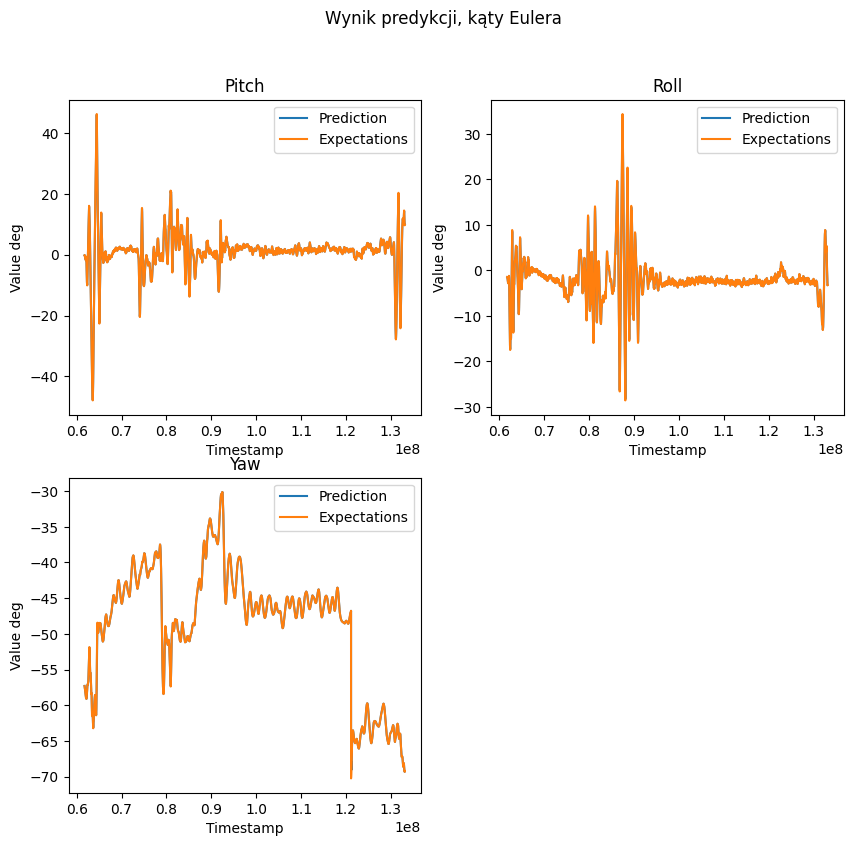

In [95]:
from library.quaternion_vision import display_quaternion_as_euler

display_quaternion_as_euler(
    [pred_q, ex_q], 
    [pred_t, ex_t],  
    ['Prediction', 'Expectations'],
    "Wynik predykcji, kąty Eulera")

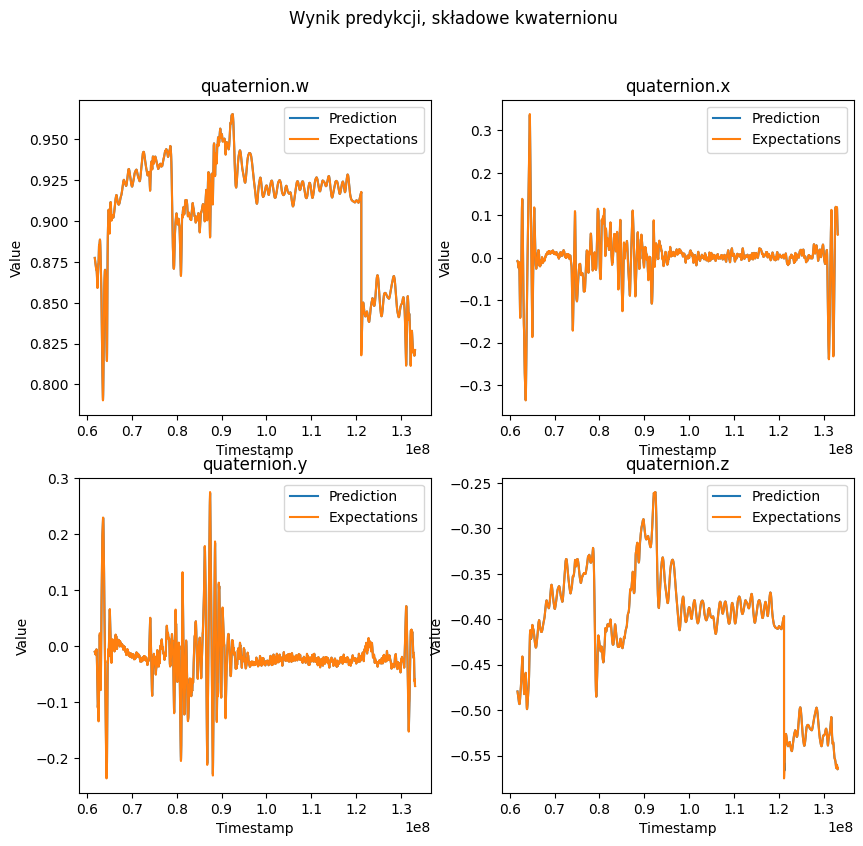

In [96]:
from library.quaternion_vision import display_quaternion_compare

display_quaternion_compare(
    [pred_q, ex_q], 
    [pred_t, ex_t], 
    ['Prediction', 'Expectations'],
    "Wynik predykcji, składowe kwaternionu")